## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../src/translator_component_toolkit')
from src import translator_component_toolkit as TCT

In [5]:
# Step1: List all the APIs in the translator system
APInames = translator_component_toolkit.list_Translator_APIs()
APInames_current = translator_component_toolkit.get_Translator_APIs()
#set(APInames_current)-set(APInames)
APInames_current


['Sri-name-resolver',
 'Monarch API',
 'Complex Portal Web Service',
 'Sri-answer-appraiser(Trapi v1.5.0)',
 'LitVar API',
 'CTD API',
 'EBI Proteins API',
 'Workflow-runner(Trapi v1.5.0)',
 'Ontology Lookup Service API',
 'Cqs(Trapi v1.5.0)',
 'Automat-monarchinitiative(Trapi v1.5.0)',
 'QuickGO API',
 'RaMP API v1.0.1',
 'Automat-genome-alliance(Trapi v1.5.0)',
 'Connections Hypothesis Provider API',
 'Automat-gwas-catalog(Trapi v1.5.0)',
 'mediKanren',
 'Automat-hmdb(Trapi v1.5.0)',
 'Automat-robokop(Trapi v1.5.0)',
 'Automat-hgnc(Trapi v1.5.0)',
 'Sri-node-normalizer(Trapi v1.5.0)',
 'Automat-binding-db(Trapi v1.5.0)',
 'Automat-gtex(Trapi v1.5.0)',
 'Automat-reactome(Trapi v1.5.0)',
 'Automat-ehr-may-treat-kp(Trapi v1.5.0)',
 'Automat-gtopdb(Trapi v1.5.0)',
 'Autonomous Relay System (ARS) TRAPI',
 'Automat-human-goa(Trapi v1.5.0)',
 'Automat-pharos(Trapi v1.5.0)',
 'Automat-cam-kp(Trapi v1.5.0)',
 'Automat-viral-proteome(Trapi v1.5.0)',
 'Automat-string-db(Trapi v1.5.0)',
 'Automa

In [6]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = translator_component_toolkit.get_KP_metadata(APInames) # This only applies to the Translator APIs
print(metaKG.columns)
print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

Index(['API', 'KG_category', 'Subject', 'Object', 'URL'], dtype='object')
(9288, 5)


In [7]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'NPM1'
input_node1_id = translator_component_toolkit.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
#input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(translator_component_toolkit.select_concept(sub_list=input_node1_category,
                                                                       obj_list=input_node2_category,
                                                                       metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = translator_component_toolkit.select_API(sub_list=input_node1_category,
                                                    obj_list=input_node2_category,
                                                    metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = translator_component_toolkit.get_Translator_API_URL(sele_APIs,
                                                               APInames)

NCBIGene:4869
all relevant predicates in Translator:
['biolink:has_part', 'biolink:directly_physically_interacts_with', 'biolink:regulates', 'biolink:genetically_associated_with', 'biolink:coexists_with', 'biolink:produced_by', 'biolink:positively_correlated_with', 'biolink:physically_interacts_with', 'biolink:affects', 'biolink:correlated_with', 'biolink:regulated_by', 'biolink:genetically_interacts_with', 'biolink:derives_from', 'biolink:affected_by', 'biolink:part_of', 'biolink:close_match', 'biolink:associated_with', 'biolink:derives_into', 'biolink:homologous_to', 'biolink:associated_with_resistance_to', 'biolink:related_to', 'biolink:negatively_correlated_with', 'biolink:associated_with_sensitivity_to', 'biolink:produces', 'biolink:interacts_with']
all relevant APIs in Translator:
['BioThings Explorer (BTE) TRAPI', 'Text Mining Targeted Association API', 'PharmGKB REST API', 'Biothings Explorer (BTE)', 'Connections Hypothesis Provider API', 'MolePro', 'BioThings SEMMEDDB API', 'M

In [8]:
# Step 4: Format query json
query_json = translator_component_toolkit.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                                            input_node2_list,  # it can be empty list if only want to query node1
                                                            input_node1_category,  # a list of categories of input node1
                                                            input_node2_category,  # a list of categories of input node2
                                                            sele_predicates) # a list of predicates

# Step 5: Query Translator APIs and parse results
result = translator_component_toolkit.parallel_api_query(API_URLs, query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = translator_component_toolkit.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = translator_component_toolkit.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


'https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query' generated an exception: HTTPSConnectionPool(host='api.bte.ncats.io', port=443): Max retries exceeded with url: /v1/smartapi/978fe380a147a8641caf72320862697b/query (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'api.bte.ncats.io'. (_ssl.c:1000)")))
'https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query' generated an exception: HTTPSConnectionPool(host='api.bte.ncats.io', port=443): Max retries exceeded with url: /v1/smartapi/978fe380a147a8641caf72320862697b/query (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'api.bte.ncats.io'. (_ssl.c:1000)")))
'https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query' generated an exception: HTTPSConnectionPool(host='api.bte.n

In [10]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:4869'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Gene']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:physically_interacts_with', 'biolink:has_part', 'biolink:genetic_association', 'biolink:regulated_by', 'biolink:correlated_with', 'biolink:homologous_to', 'biolink:coexpressed_with', 'biolink:negatively_correlated_with', 'biolink:orthologous_to', 'biolink:genetically_associated_with', 'biolink:binds', 'biolink:derives_from', 'biolink:affects', 'biolink:has_input', 'biolink:subclass_of', 'biolink:affected_by', 'biolink:part_of', 'biolink:coexists_with', 'biolink:biomarker_for', 'biolink:related_to', 'biolink:contributes_to', 'biolink:interacts_with', 'biolink:regulates', 'biolink:produced_by', 'biolink:derives_into', 'biolink:close_match', 'biolink:produces', 'biolink:genetically_interacts_with', 'biolink:directly_physically_interacts_with', 'biolink:has_phenotype', 'bio

NCBIGene:6052:no preferred name


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

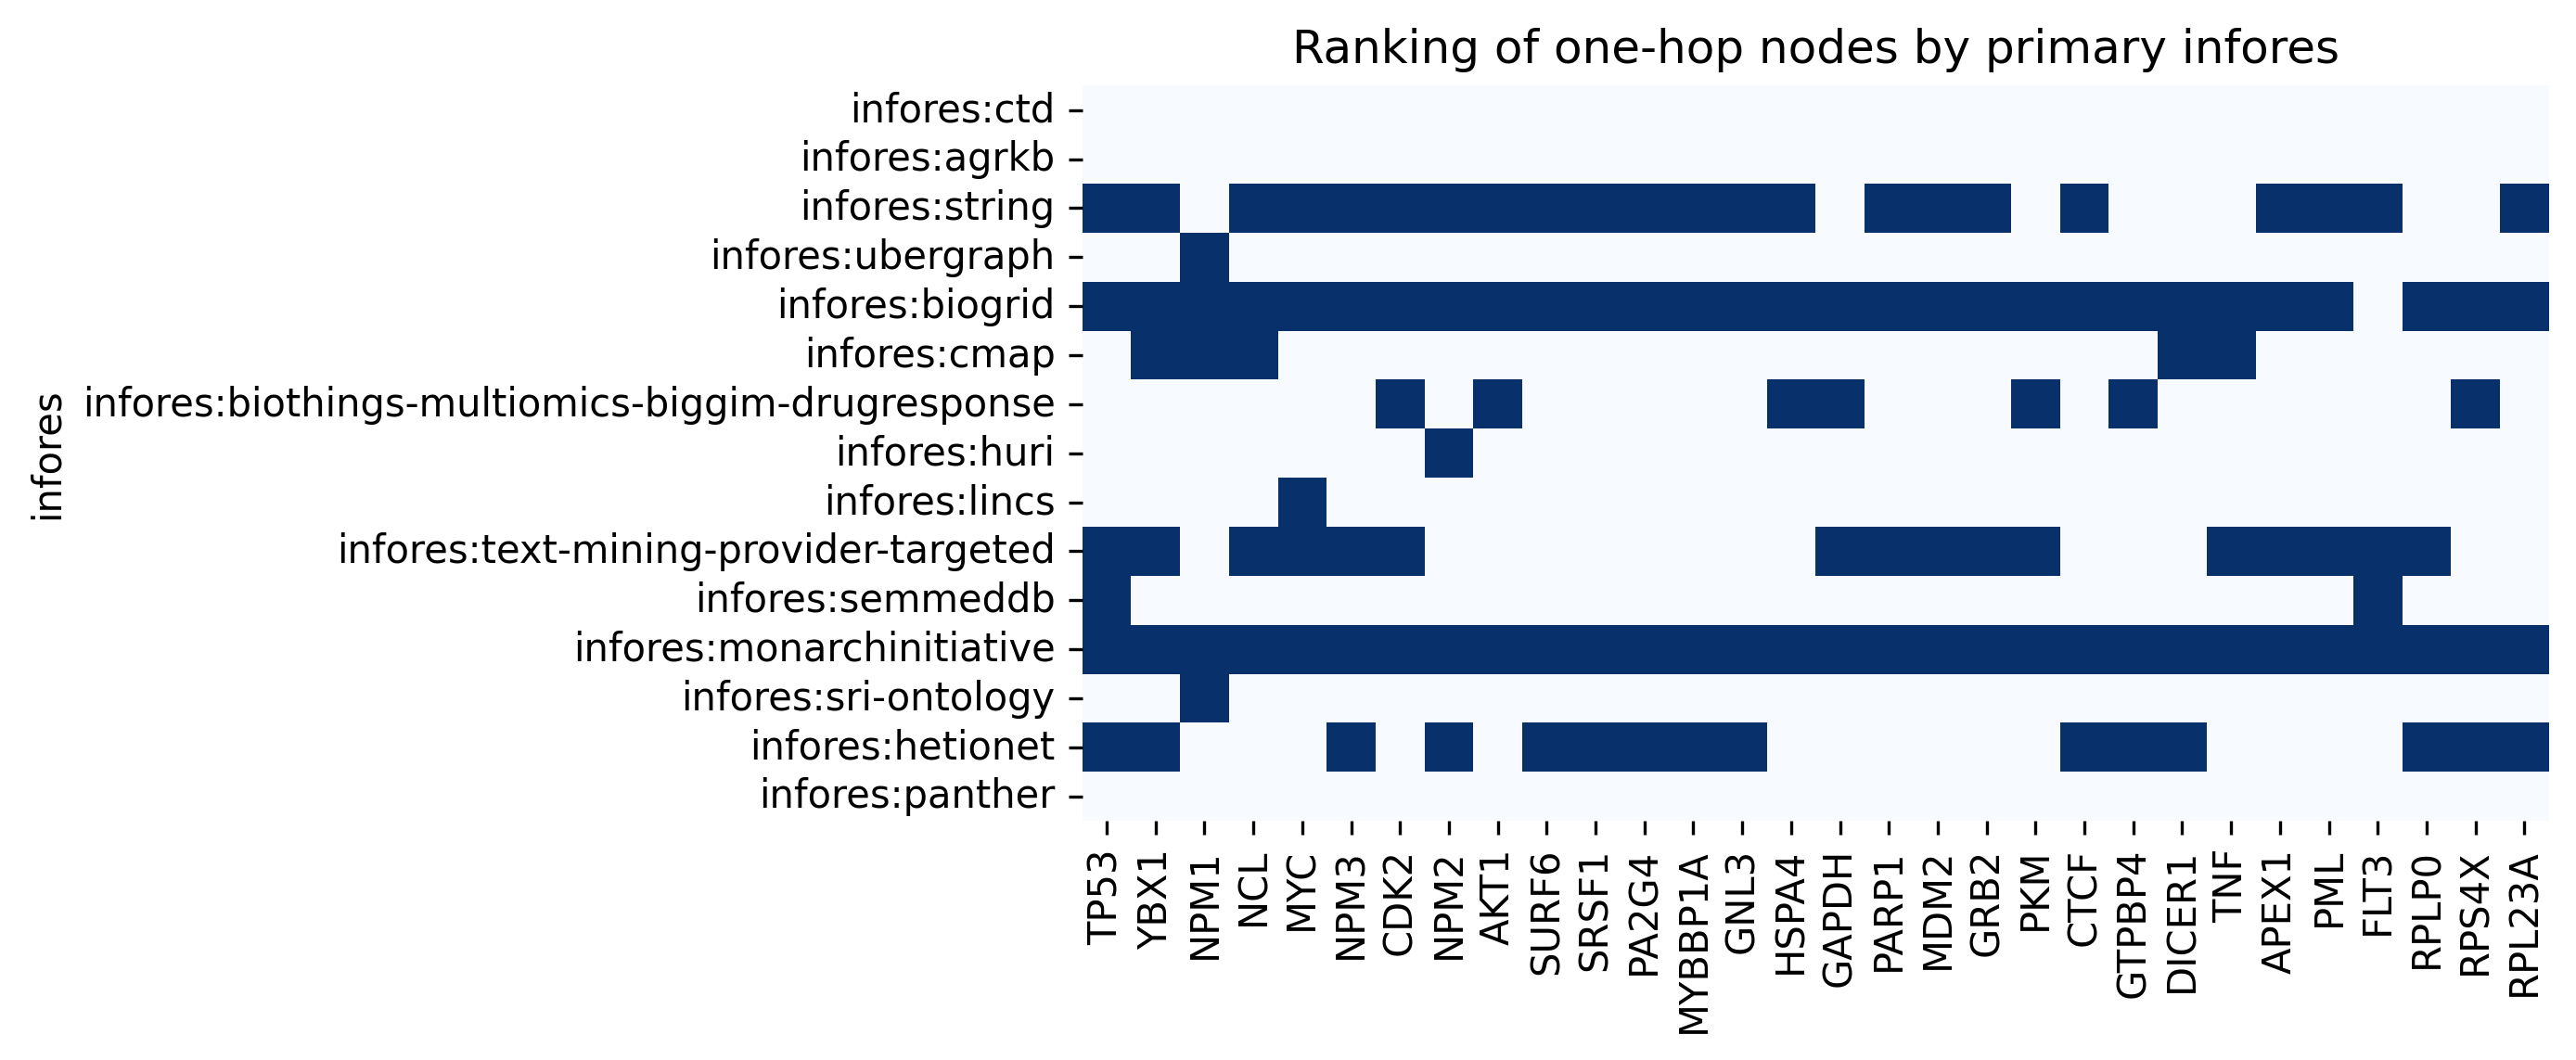

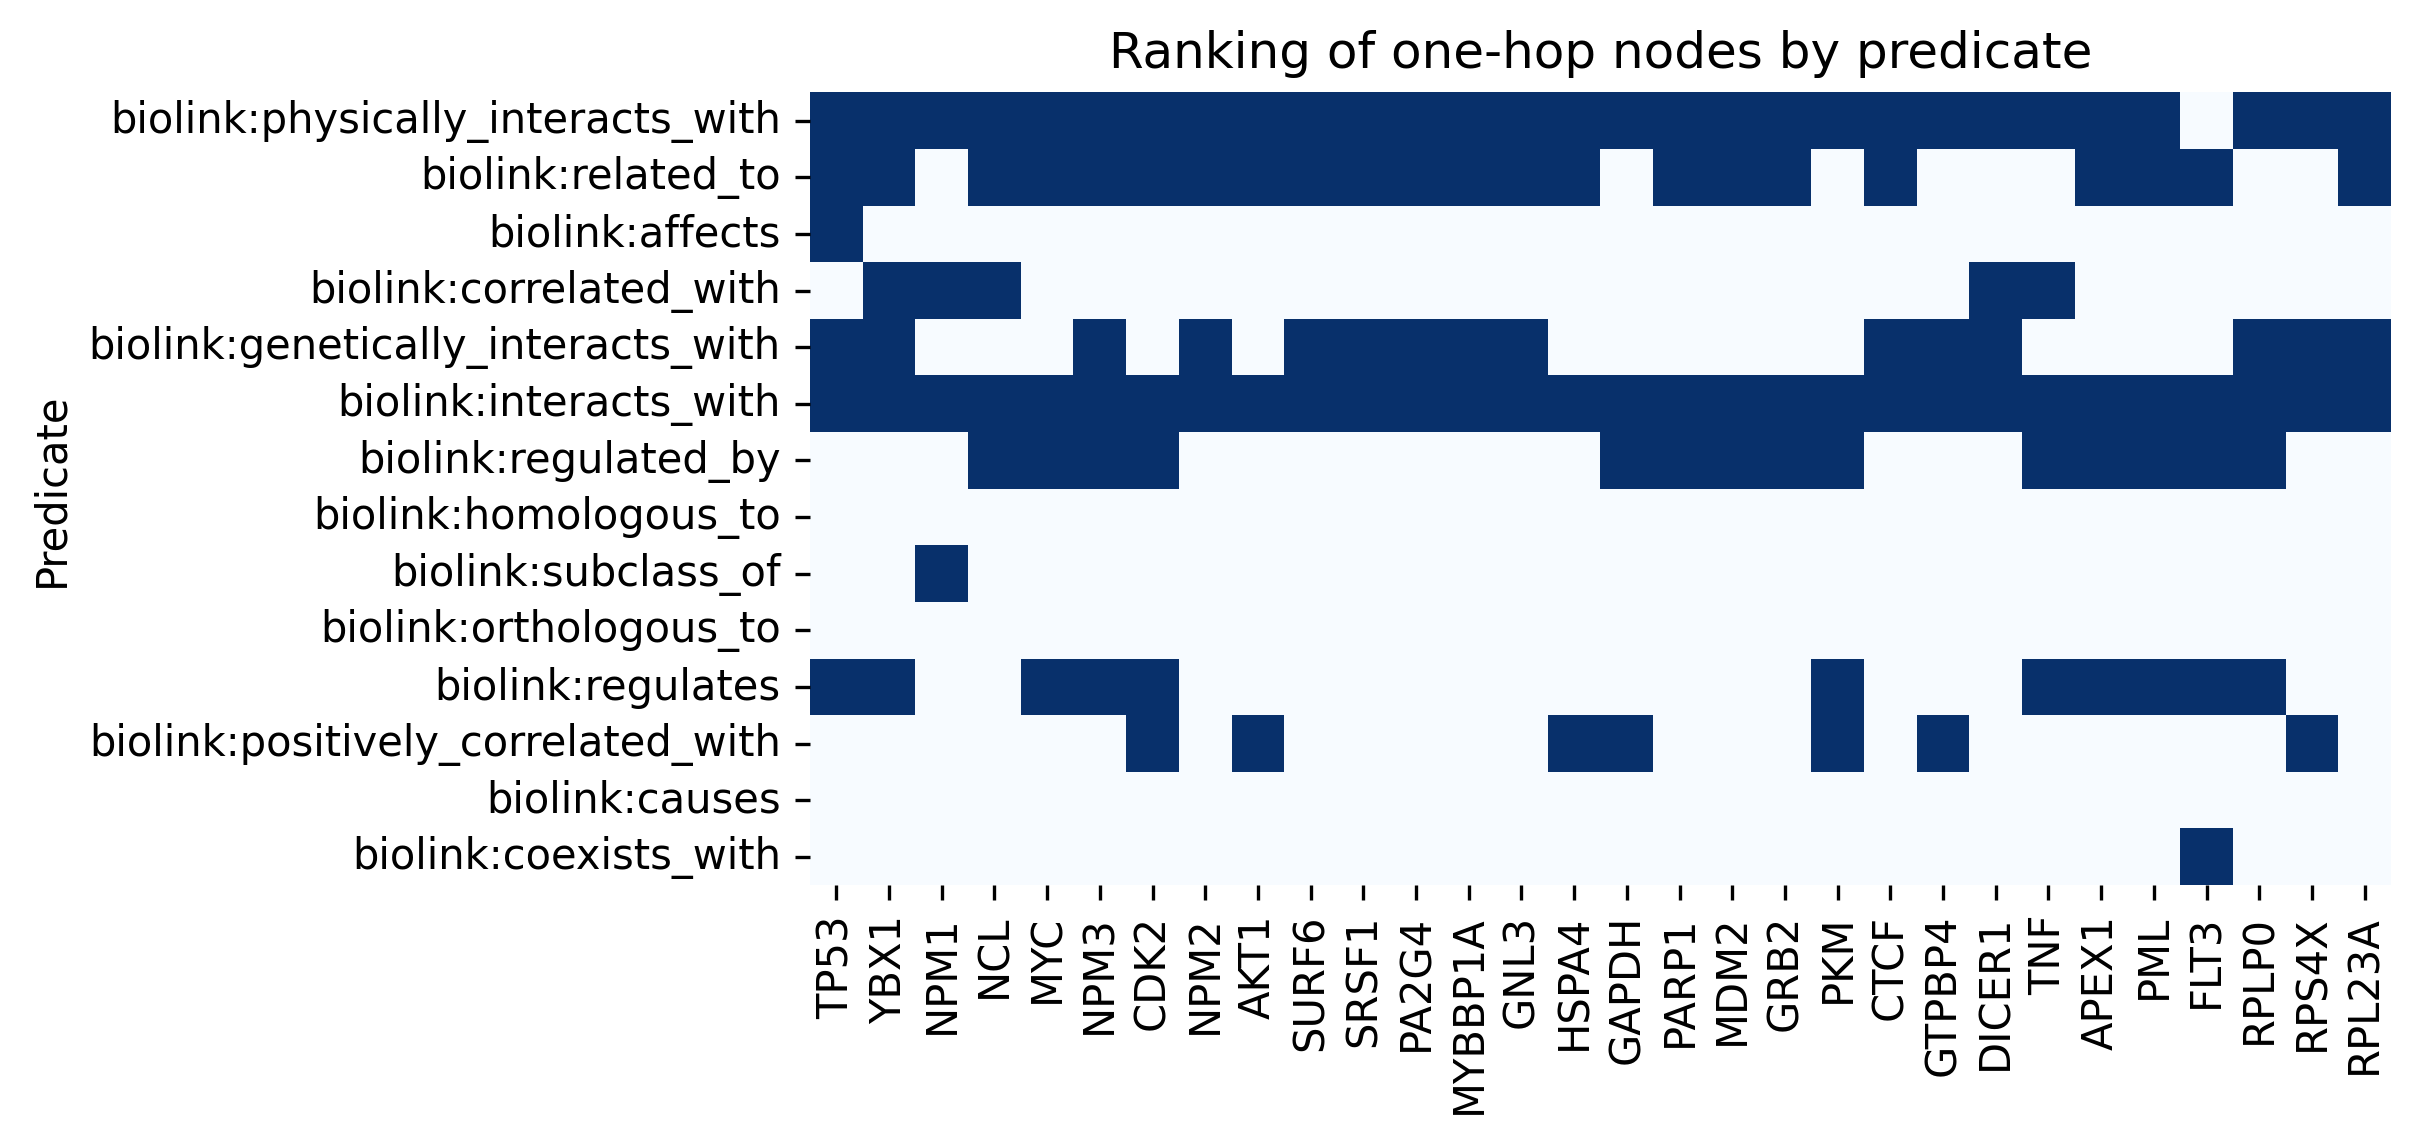

In [8]:
# Step 8: Visualize the results
translator_component_toolkit.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed,
                                                          num_of_nodes = 30, input_query = input_node1_id,
                                                          fontsize = 10)


In [8]:
# End of the example